# 发现的一些问题
## 关于$\gamma$的估计
之前估计的$\gamma$ 的精度一直不高, 而且精度经常不随样本变多而明显提高，尤其是第二个模型，最早一直认为是连续变量的系数估计的不够好，我最近发现应该是下面这些问题。

$y = X \alpha + Z \beta + g(X, Z) + 0.2\epsilon$

其中

$g_1 = log( 1 + exp( X \theta + Z \gamma - 1))$

$g_2 = cdf(0.1( X \theta + Z \gamma - 1)^2)$

$cdf(u)$ 为标准正态分布的累计密度函数

$Z = [z_1, z_2, z_3, z_4]$

$r$ ~ $U(0,1)$

$z_1 = 1$ when $r < P$

$z_2 = 1$ when $P < r < 2P$

$z_3 = 1$ when $2P < r < 3P$

$z_4 = 1$ when $3P < r < 4P$

$4P \leq 1$

这个定义下$4P = 1$时, 即没有取值全为0的$Z$

实验中发现，这种情况下$\gamma$解似乎不唯一

## 关于$\beta$的估计

$\beta$ 只有在$\gamma$估计出来后才能准确估计，或者用local linear对两者一起估计，否则总是会带有$\gamma$的信息

因为这个原因，这个模型很难用迭代法求解

In [1]:
include("./src/qgplsim.ji")
include("./src/DGP.ji")
include("./src/supportFunctions.ji")

tabular (generic function with 2 methods)

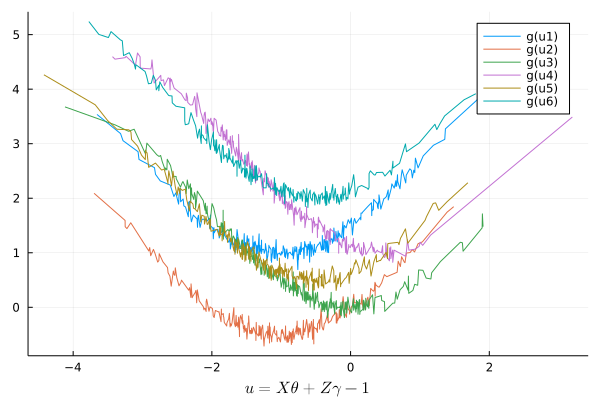

In [2]:
using LaTeXStrings

α = [1.0, -0.5] 
θ = [1.0, 2.0]  
θ = θ/norm(θ)
β = [1.0, -0.5, 1.0] * 1.0 # 
γ = [1.0, 1.0, -0.5] * 1.0 #

n = 2000
etp = 1
yx(x) = sin(x/2)*x
ytp = 1
X, y, Z = xyz(n, α, β, θ, γ, etp, yx)
catag, index = collection(Z)
ncateg = index.count

using Plots
plot()
for k in 1:ncateg
    zk = catag[k]
    indk = index[zk]
    Xk = X[indk, :]
    yk = y[indk] - Xk * α
    uk = Xk*θ  .- 1  # .+ zk' * γ
    ind = sortperm(uk)
    plot!(uk[ind], yk[ind], label = "g(u$k)")
end
xlabel!(L"u = X \theta + Z \gamma - 1")

In [4]:
τ = [0.5]
# τ = [0.25, 0.5, 0.75]
widthExp = -0.2
model1 = qgplsim.model(X, Z, y, τ, widthExp)
@time qgplsim.estimator(model1, method)
qgplsim.print_model(model1)

  6.708978 seconds (26.89 M allocations: 2.869 GiB, 4.89% gc time)
alpha => [1.0015, -0.5057]
theta => [0.4508, 0.8926]
gamma => [1.0349, 1.0225, -0.531]
beta => [1.0012, -0.4982, 0.9983]


## Monte Carlo

In [26]:
using Base.Threads

In [339]:
include("./src/qgplsim.ji")
include("./src/DGP.ji")
N = [500, 1000]
Etype = [1,2,3,4]
ytype = 2
len_n = length(N)
len_e = length(Etype)

meanEE_theta = zeros(len_n, len_e)
stdEE_theta = zeros(len_n, len_e)

mean_alpha = zeros(len_n, len_e)
std_alpha = zeros(len_n, len_e)

mean_gamma = zeros(len_n, len_e)
std_gamma = zeros(len_n, len_e)

mean_beta = zeros(len_n, len_e)
std_beta = zeros(len_n, len_e)

n_repeat = 100
widthExp = -0.2

α = [1, -2]
θ = [2, 1]/sqrt(5)
β = [1.0, -0.5, 1.0] * 1.0 # 
γ = [1.0, 1.0, -0.5] * 1.0 #
tau = [0.5]

p = length(α)
q = length(β)

@threads for j in 1:len_e
    
    etype = Etype[j]    
    
    for i in 1:len_n  

        n = N[i] 
       
        Alpha = zeros(n_repeat, p)
        Theta = zeros(n_repeat, p)
        Beta = zeros(n_repeat, q)
        Gamma = zeros(n_repeat, q)
        
        for k in 1:n_repeat
            
            X, y, Z = xyz(n, α, β, θ, γ, etype, ytype)
            modelk = qgplsim.model(X, Z, y, tau, widthExp)
            qgplsim.estimator(modelk)
            Alpha[k, :] = modelk.alpha
            Theta[k, :] = modelk.theta
            Beta[k, :] = modelk.beta
            Gamma[k,:] = modelk.gamma
            
        end
        # println(mean(Gamma, dims = 1))
        EE = sqrt.(1 .- abs.(Theta * θ)) 
        meanEE_theta[i,j] = mean(EE)
        stdEE_theta[i,j] = std(EE)
        mean_alpha[i,j], std_alpha[i,j] = euclid(Alpha, α)
        mean_gamma[i,j], std_gamma[i,j] = euclid(Gamma, γ)
        mean_beta[i,j], std_beta[i,j] = euclid(Beta, β)

        
    end
end

In [340]:
table_alpha = tabular(mean_alpha, std_alpha)

2×4 Matrix{String}:
 "0.0305(.0210)"  "0.0137(.0105)"  "0.0422(.1389)"  "0.1043(.1488)"
 "0.0189(.0138)"  "0.0098(.0078)"  "0.0504(.1585)"  "0.0378(.0542)"

In [341]:
table_beta = tabular(mean_beta, std_beta)

2×4 Matrix{String}:
 "0.0463(.0296)"  "0.0268(.0170)"  "0.1224(.2290)"  "0.1222(.1630)"
 "0.0335(.0223)"  "0.0163(.0127)"  "0.4667(.5014)"  "0.0551(.0475)"

In [342]:
table_theta = tabular(meanEE_theta, stdEE_theta)

2×4 Matrix{String}:
 "0.0214(.0150)"  "0.0096(.0075)"  "0.0340(.1277)"  "0.0755(.1132)"
 "0.0133(.0098)"  "0.0068(.0055)"  "0.0391(.1318)"  "0.0266(.0387)"

In [343]:
table_gamma = tabular(mean_gamma, std_gamma)

2×4 Matrix{String}:
 "0.2995(.1643)"  "0.2837(.1609)"  "0.3099(.2035)"  "0.2982(.1573)"
 "0.2099(.1247)"  "0.1474(.0919)"  "0.1768(.1230)"  "0.1913(.1294)"

In [344]:
table_sum = [table_alpha; table_theta; table_beta; table_gamma]

8×4 Matrix{String}:
 "0.0305(.0210)"  "0.0137(.0105)"  "0.0422(.1389)"  "0.1043(.1488)"
 "0.0189(.0138)"  "0.0098(.0078)"  "0.0504(.1585)"  "0.0378(.0542)"
 "0.0214(.0150)"  "0.0096(.0075)"  "0.0340(.1277)"  "0.0755(.1132)"
 "0.0133(.0098)"  "0.0068(.0055)"  "0.0391(.1318)"  "0.0266(.0387)"
 "0.0463(.0296)"  "0.0268(.0170)"  "0.1224(.2290)"  "0.1222(.1630)"
 "0.0335(.0223)"  "0.0163(.0127)"  "0.4667(.5014)"  "0.0551(.0475)"
 "0.2995(.1643)"  "0.2837(.1609)"  "0.3099(.2035)"  "0.2982(.1573)"
 "0.2099(.1247)"  "0.1474(.0919)"  "0.1768(.1230)"  "0.1913(.1294)"

In [345]:
using DataFrames, CSV
df = DataFrame(table_sum)
CSV.write("model2.csv", df)

"model2.csv"